In [1]:
import math
import numpy as np
# set to relevant for environment, widget works best within VSCode
%matplotlib widget

from IPython.display import Image, SVG, Video

np.random.seed(100)

# Abstract

Hierarchical methods for many body solutions to Poisson's Equation in 2D were considered. These were the Barnes-Hut ($O(Nlog(N))$) and the Fast Multipole Method ($O(N)$). Comparison was made with the direct pairwise interaction of all particles within the system ($O(N^2)$). The methodology behind, and implementation of, each of these methods are described. Power law fits for the computational complexity of the form $N^p$ were calculated, giving $p=1.38$ and $p=1.07$ for the Barnes-Hut and Fast Multipole Method respectively; it is also seen that Barnes-Hut begins to follow $O(N \log(N))$ for large $N$. Analysis of the errors within these methods was undertaken, along with further analysis of the time scaling due to the various parameters within each method. Application of these methods to many body simulations was made, however large computation times and issues with divergences were encountered here. 

# Introduction

Within this project, various schemes for computational simulation of many body problems are considered. In general, these problems consider $N$ different bodies, which all interact with all other $N-1$ bodies within the simulation. Naive implementation of this will therefore have time dependance on particle number $N$ of $O(N^2)$, quickly becoming infeasible for large numbers of particles. 
Here we consider hierarchical methods that can reduce the computational complexity, namely the Barnes-Hut (BH) and Fast Multipole Method (FMM) schemes. These were originally developed by Barnes and Hut (1986) and Greengard and Rokhlin (1987) respective. For large particle numbers $N$, these schemes provide $O(N \log(N))$ and $O(N)$ scaling, a significant improvement over simple pairwise interaction. 

# Background


Within this report we constrict consideration only to pairwise interaction due to solutions of Poisson's Equations in 2D. 
That being solutions to the equation of the form, 
$$
\nabla^2 \varphi(x, y) = \left(\frac{\partial^2}{\partial x} + \frac{\partial^2}{\partial x} \right) \varphi(x, y) = f(x, y) \, .
$$
Physically, the most common manefestations of this appears within gravitational and Coloumbic interactions, with respective equations (strictly these are for 3D cases with the given constants, but the forms persist to 2D), 
$$
\nabla^2 \phi = 4 \pi G \rho \quad \text{and} \quad
\nabla^2 \phi = - \frac{\rho}{\epsilon \epsilon_0} \, .
$$


Taking the case of the Coloumb-like interaction (like repulsive), consider a unit point charge at $(x_p, y_p) = \mathbf{x}_p \in \mathbb{R}^2$. Then at another point $(x, y) = \mathbf{x} \in \mathbb{R}^2$, the potential and electrostatic field are given as, 
$$
\phi_{\mathbf{x}_p}(x, y) = - \log(\| \mathbf{x} - \mathbf{x}_p \|) \, , \qquad
\mathbf{E}_{\mathbf{x}_p}(x, y) = \frac{(\mathbf{x} - \mathbf{x}_p)}{\| \mathbf{x} - \mathbf{x}_p \|^2} \, .
$$
Appropriate constants can be considered through simple multiplication of some factor, say $k$, and charge then considered with some $q$. Giving for example, 
$$
\phi_{\mathbf{x}_p}(x, y) = - k q \log(\| \mathbf{x} - \mathbf{x}_p \|) \, ,
$$
For like repulsion (Coloumbic) we then take $k>0$, and for like attraction (gravity) we take $k<0$. 


As described in Greengard et al. 1987, this 2D case is then naturally brought into the complex domain. This allows us to instead write the potential as 
$$
\phi_{\mathbf{x}_0}(\mathbf{x}) = - \log(|z - z_p|)= \Re\{- \log(z - z_p)\} = \Re\{- w(x, y)\} \, ,
$$
where we have $w(x, y) = \log(z - z_p)$, and $x + iy = z \in \mathbb{C}$ is used to describe points in the plane. 

To get the force from this expression, use of the Cauchy-Riemann equations gives, for $u(x, y) = \Re\{w(x, y)\}$, 
$$
\nabla u = (u_x, u_y) = (\Re\{w'\}, -\Im\{w'\}) \, ,
$$
and hence in our case for $E = - \nabla \phi$ and $\phi = \Re\{-w\}$, we have
$$
\mathbf{E}_{\mathbf{x}_0} = \frac{(\Re\{z-z_p\}, \Im\{z-z_0\})}{|z-z_p|} = (\Re\{w'\}, -\Im\{w'\}) \, ,
$$
where we will see that the first form is relevant for near interaction, and the second for far-field. 

Within the rest of the report we take, for convinience, simply $\phi = + \log(z)$, instead of the more correct definition of $\phi$ being negative. This has no effect on the underlying methods or mathematics. 

# Method

Code is presented within this section where useful for explanation. The full codebase can however be found in [packages](packages), of which reference will be made to. 

In [2]:
import packages
from packages import general, bh, fmm

## Setup

This project will considers interactions between some number of so called particles, within a square box of unit side length, for $0 \le x \le 1, \, 0 \le y \le 1$. 
Hence to begin, `Point` and `Particle` classes are made ([packages/general/point.py](packages/general/point.py) and [/particle.py](packages/general/particle.py)). 

`Particle`s have a `centre` (inherited from `Point`) and `charge` associated with each, if unspecified, these will be set to a `centre` inside the unit box, and a random `charge` from $-1$ to $1$ However, specifying `mass_like=True` will restrict this to only positive values. Within this report we will use mass to refer simply to charges in a collection in which they are all positive. 

Each `Particle` also has a `potential` and `force_per` to accumulate the relevant potentials and forces. Force per referes to the force felt by that particle if it were unit charge, hence the force it will actually feel will be `charge * force_per`, like the total field felt by the charge. 

In order to aid with the Centre of Mass approximation for the later Barnes-Hut method, we will currently restrict charges to be mass like. 

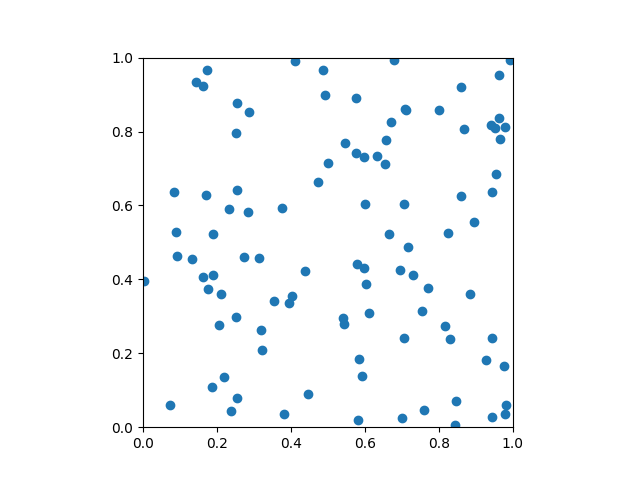

In [3]:
num_particles = 100
particles = [general.Particle(mass_like=True) for _ in range(num_particles)]
import report_plots
fig = report_plots.plot(particles)


## Pairwise Interaction

We begin with the algorithm for direct pairwise interation. We simply consider each particle in turn and then sum together all of these interactions. 
$$
\phi_i = \sum_{j, \, i \neq j} - q_j log(|z_i - z_j|), \quad
\mathbf{E}_i = \sum_{j, \, i \neq j} q_j \frac{(\Re\{z_i - z_j\}, \, \Im\{z_i - z_j\})}{|z_i - z_j|^2} \, .
$$
As typical with pairwise interactions, this can be simplified as, 
$$
\phi_i = \sum_{j>i} - q_j log(|z_i - z_j|) \, ,
$$
as long as the opposing effect for the second particle is considered also in each case (as below). This reduces operations from $N^2$ to $\frac{1}{2} N(N-1)$, a marginal gain and still $O(N^2)$. 
A simple implementation of the code is given below, with the full algorithm found in [packages/general/pairwise.py](packages/general/pairwise.py). 

This method is considered to be correct, and is used as a basis for comparison for the other methods considered, as its accuracy is only limited by the precision to which the values are stored. 

In [4]:
# ensure all values are initially 0 before summing through
def reset_particle_values(particles):
    for p in particles:
        p.potential = 0.0
        p.force_per = np.zeros_like(p.force_per)

reset_particle_values(particles)

for i, particle in enumerate(particles):
    for other in particles[i+1:]:
        potential = - math.log(abs(particle.centre - other.centre))
        particle.potential += other.charge * potential
        other.potential += particle.charge * potential

        z0 = particle.centre - other.centre
        # over_r the 1/r term, or force per self*other charge
        over_r = np.array((z0.real, z0.imag)) / abs(z0)**2
        particle.force_per += other.charge * over_r
        other.force_per -= particle.charge * over_r  

pair_potentials = np.array([p.potential for p in particles])
pair_forces = np.array([p.force_per for p in particles])

## Barnes-Hut

We can now move to the first of the two hierachical methods considered here, the Barnes-Hut algorithm, as first presented by Barnes and Hut 1986. Implementation of much of the tree structure was made in reference to code from [barbagroup/FMM_tutorial](https://github.com/barbagroup/FMM_tutorial). 
In principle, this method focuses on recursive placement of the set of particles in finer and finer grained cells. These cells will be stored in a tree structure (a quadtree in 2D). 
We initially start with a 'cell' (the whole unit box), and can then add particles to this. If the number of particles due to the addition of an extra is then equal to some critical value (`n_crit`) we split the cell, where in 2D this results in (up to) 4 children corresponding to the various quadrants in the parent. Children are only created as they are needed to place particles into. 

With a tree structure already somewhat present, proceeding particles are added recursively down the tree, until they reach a leaf cell (i.e. one with no children). The particle is then added here, with a check made to split the cell if the critical value of particles in that cell is reached. 

To achieve this we create a `Cell` class found in [packages/bh/cells/cell.py](packages/bh/cells/cell.py) with methods for these various functions. Namely the ability to `_add_child()`, `_split_cell()` and then `_add_particle()`. Children are created on an as needed basis when splitting, with a bitwise attribute `bit_children` used to keep track of the locations of active children. A general scheme for adding particles is given below. Splitting a cell simply involves looping through all particles in the cell, and assigning them to their revelvant child (creating one if so needed). A `max_level` is also enforced to prevent endless recursion if particles become very close to each other. 

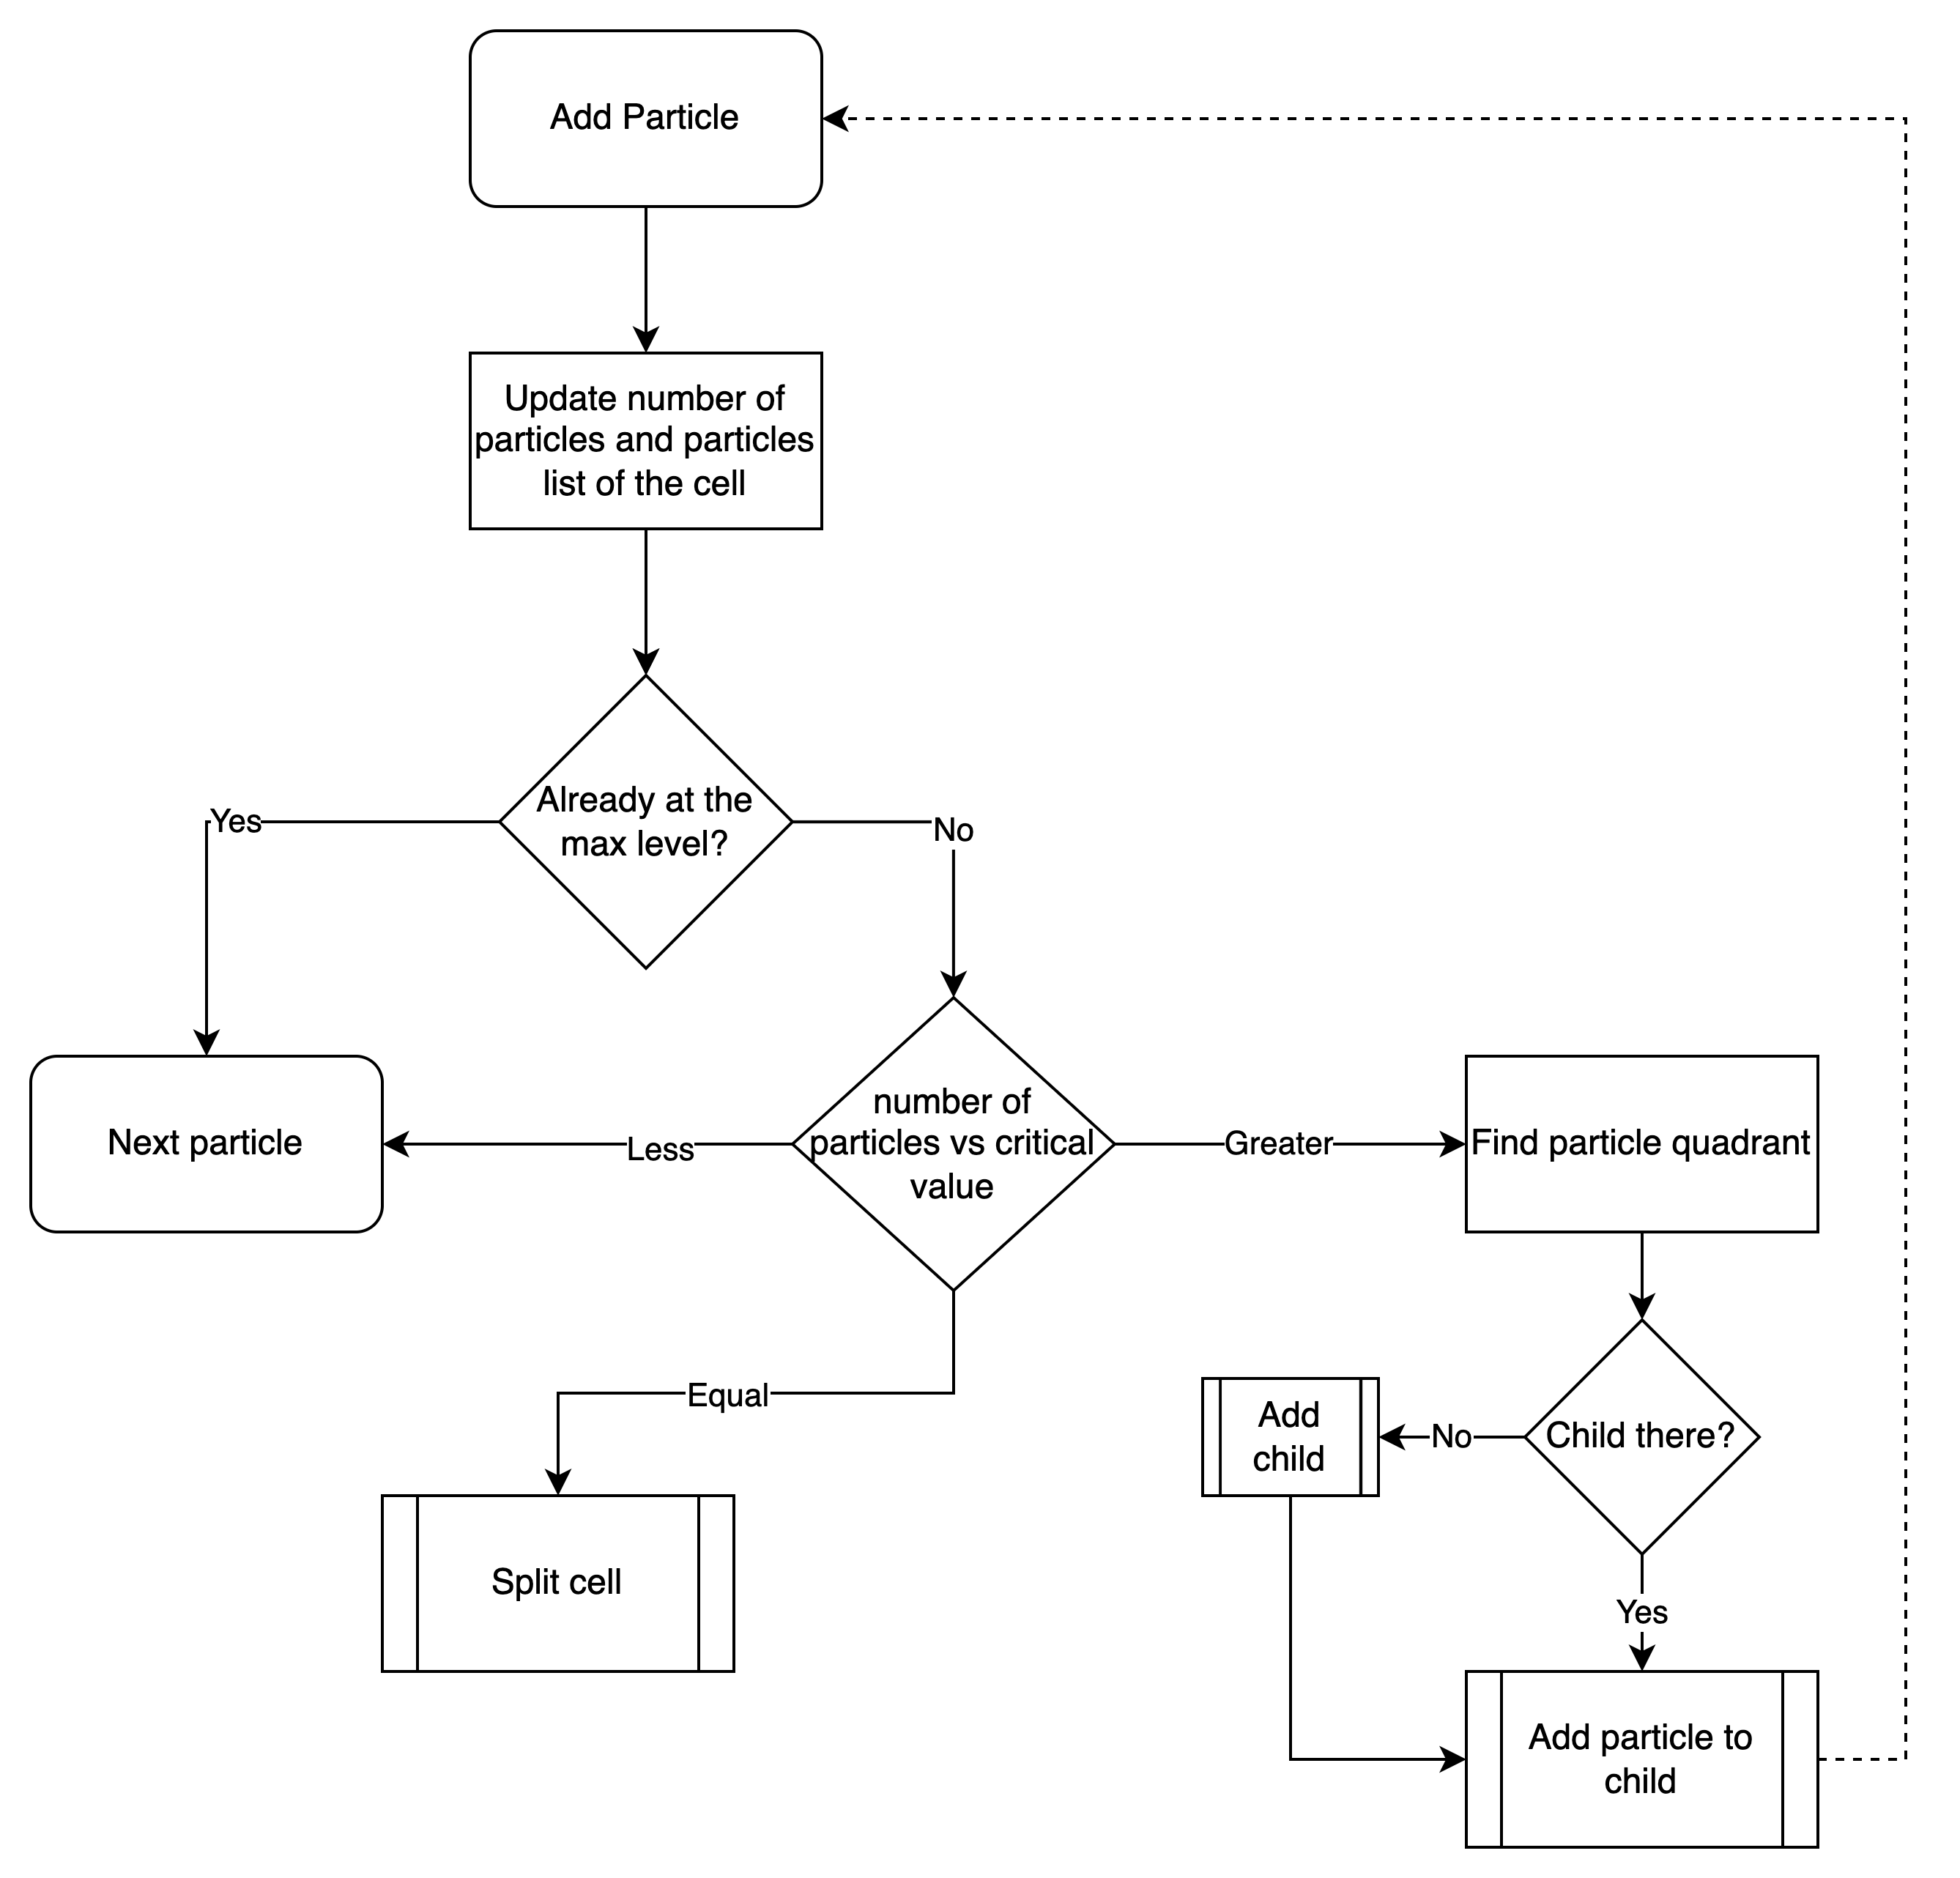

In [5]:
Image('Figures/bh_add_particle.png', width=700)

An example tree is rendered for our set of particles below. This is for `n_crit = 2`, corresponding to one particle per cell. (`max_level` is autoset, and should typically be large enough so as to not make a difference, execept for very close particles). 

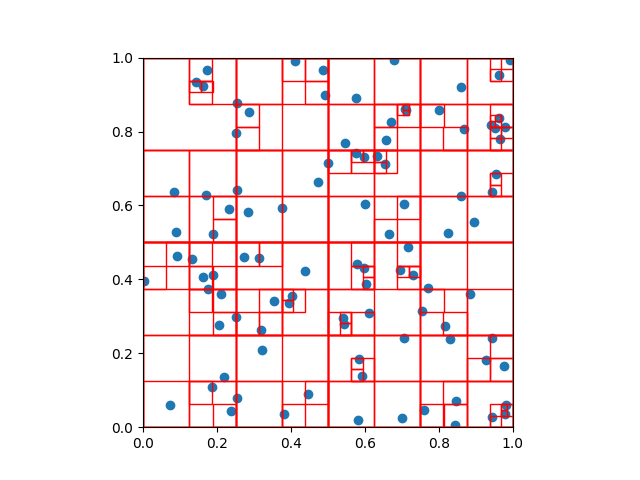

In [6]:
n_crit = 2

temp_bh = bh.BH(particles, 0, n_crit=n_crit)
temp_bh.create_root()
temp_bh.root.create_tree()
temp_bh.plot()
del n_crit, temp_bh

With the ability to create a quadtree, we now turn to how this can be used to approximate the pairwise interaction. In the original paper this is achieved through a centre of mass approximation for collections of particles that are sufficiently far away. 

For each particle, we recursively work down the tree from the root, evaluating for each cell the ratio of the side length of the cell to the distance to the cell's centre (of mass) (or $l/D$), against a value $\theta$, which is often chosen to be $0.5$. Cells are considered to be far away in the case that 
$$
\theta > \frac{l}{D} \quad \Longrightarrow \quad l < \theta D \, .
$$
For $\theta = 0.5$ this is equivalent to cases where the distance ($D$) is greater than twice the side length of the cell ($l$). 

If this $\theta$ condition is satisfied, interaction instead proceeds with the cell. This interaction is approximated (for example centre of mass approximation) for the collection of particles in that cell. Recursion further down the given cell's branch ends there. 

Given the $\theta$ condition is not satisfied, recursion is continued through the tree, looking in turn at each cell's children, and that child's children etc. Only stopping in the case a leaf is reached, at which point pairiwise interaction must then be performed for each particle in that given cell. 
Cells containing the particle of interest are also never interacted with, instead moving directly to their children. This is unless it is a leaf with more than just the particle of interest, in which case all other particles are then interacted with. 

This code is found as part of the `RootCell` class in [packages/bh/cells/rootcell.py](packages/bh/cells/rootcell.py), under the `evaluate_particle_potentials`. A flow chart of the algorithm is given below. 

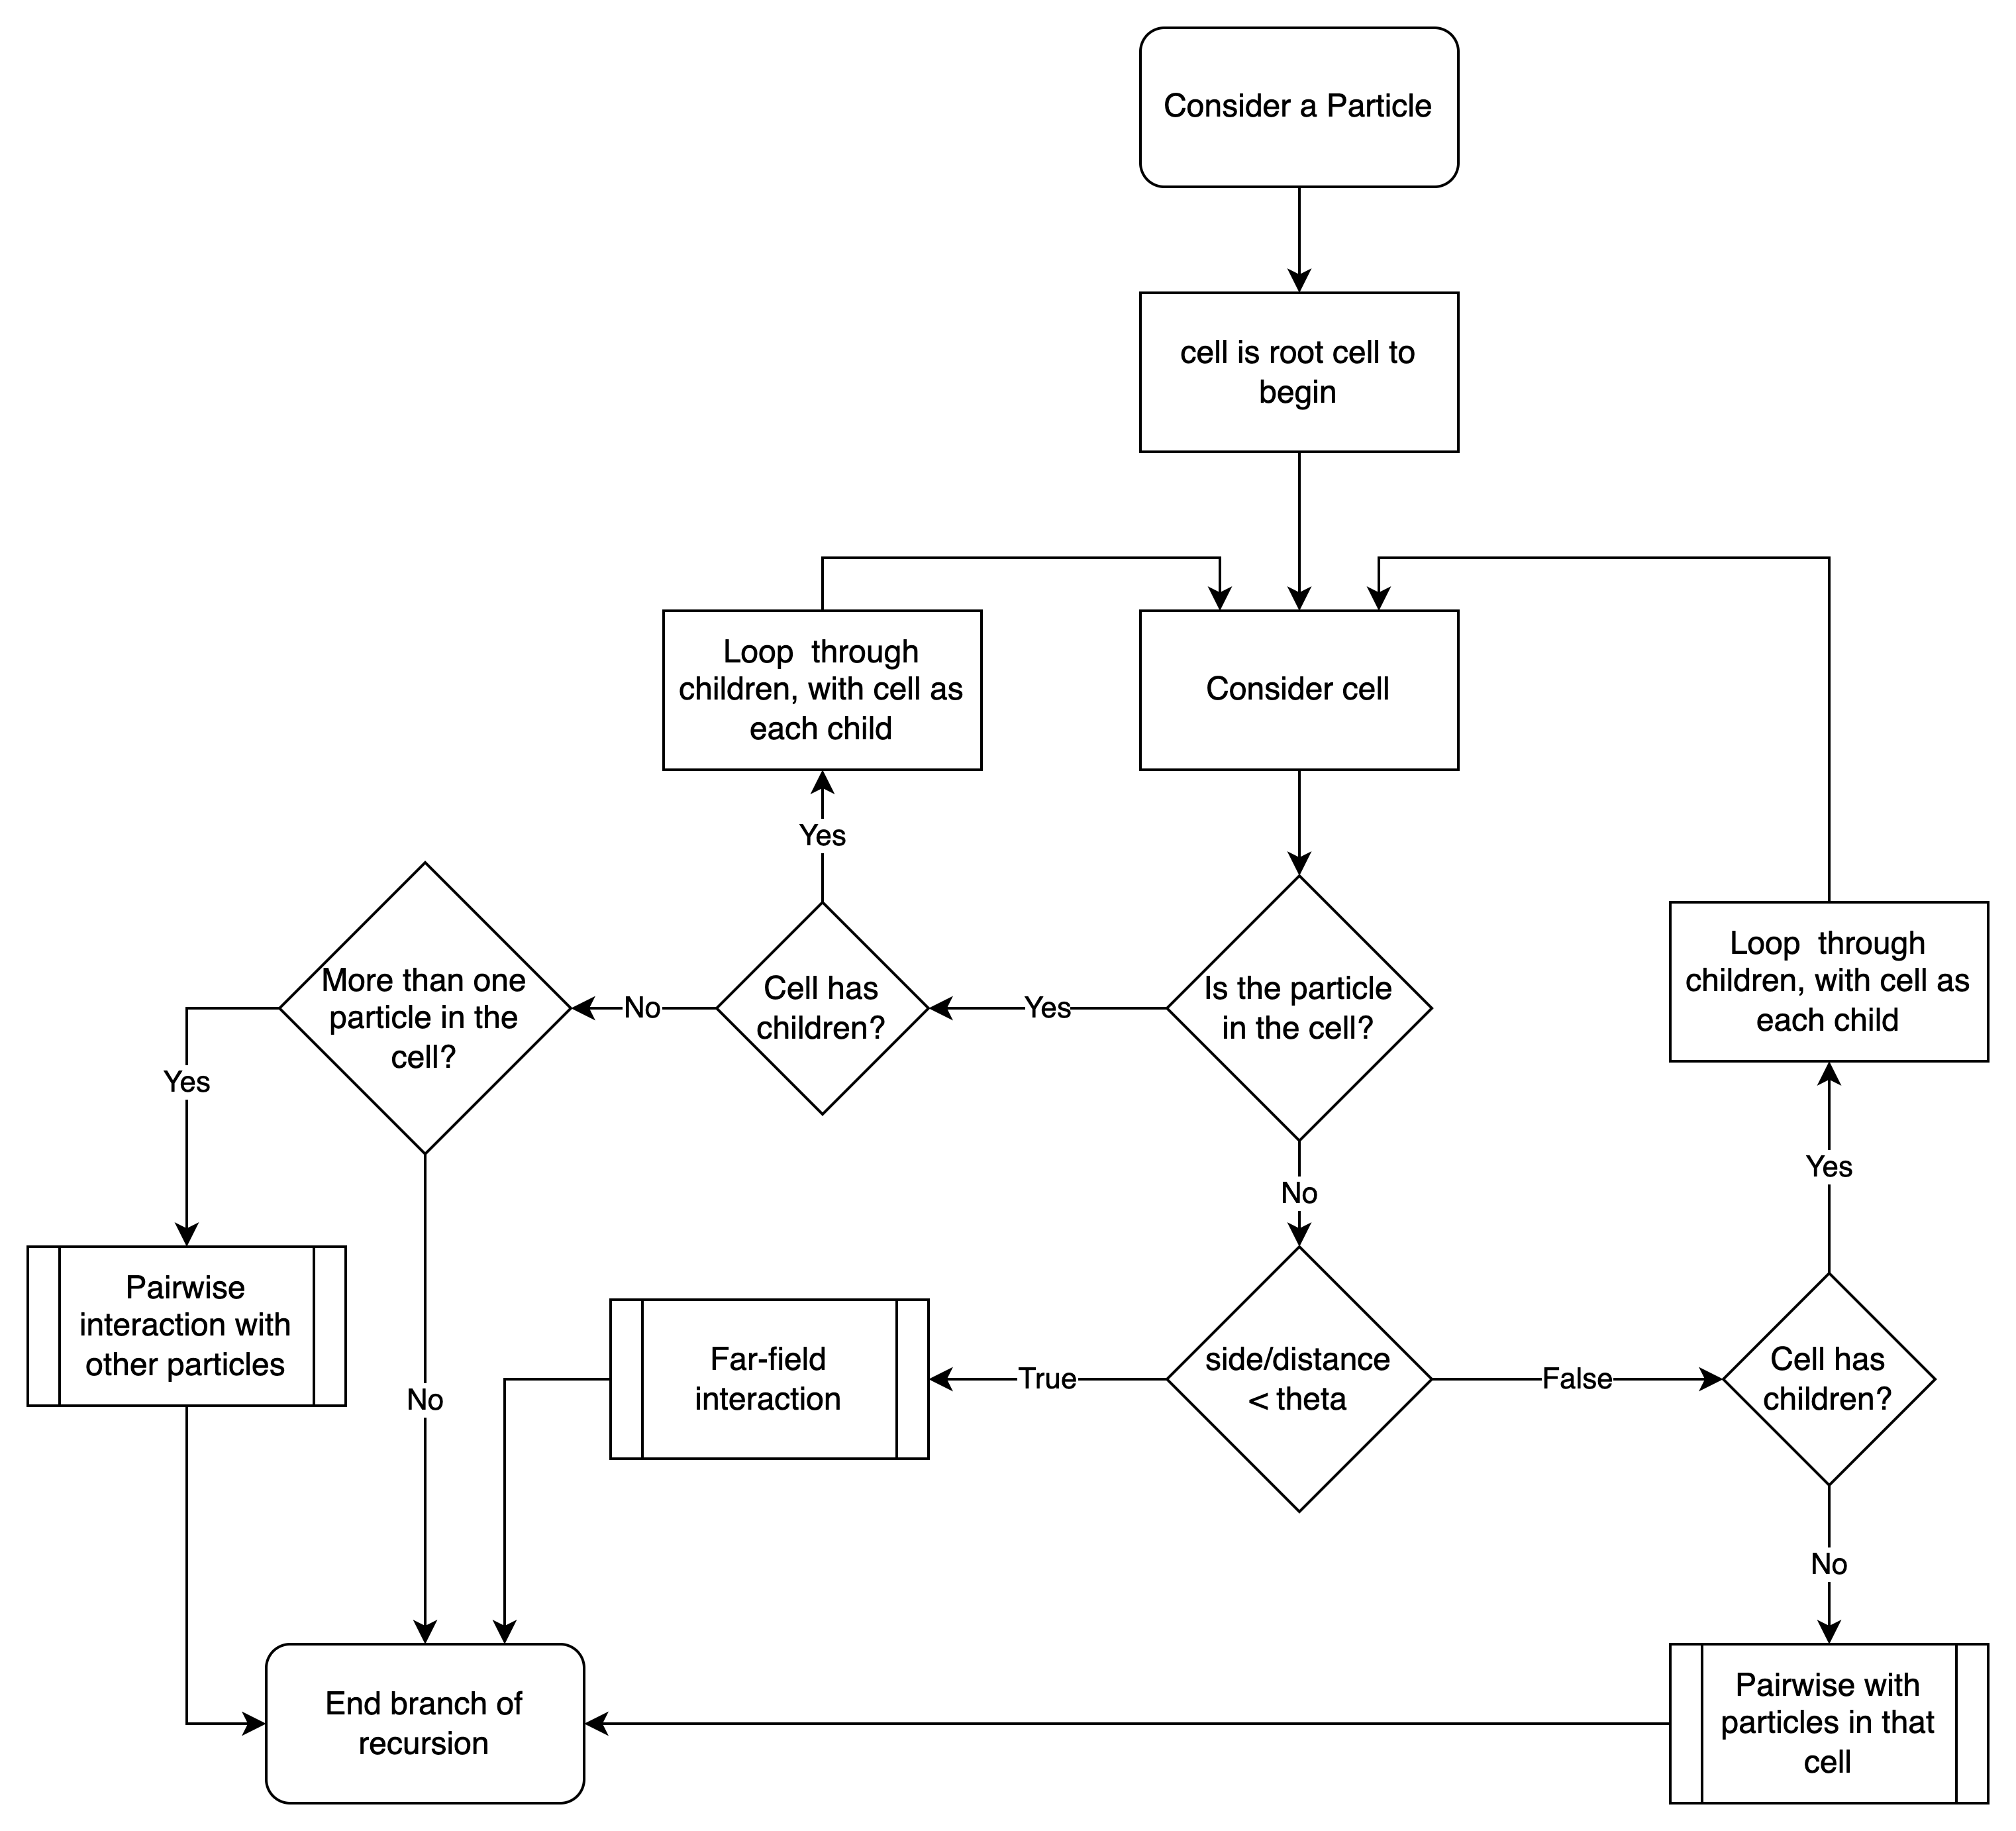

In [7]:
Image('Figures/bh_interaction.png', width=800)

### Centre of Mass Approximation

As in the paper by Barnes and Hut, we first will use this alogorithm with a centre of mass approximation (CoM) for far-field interactions. 
To do this, we first traverse the tree backwards (starting from leaf cells), calculating for each leaf the centre of mass and total mass of the cell. In the case of one particle in the cell, this is simply the particles mass and centre. 
This of course must first be done for all of a parent's children, before then considering the parent itself. This is achieved by iterating backwards through a list of `Cell`s in the tree, ordered by their creation time, hence preserving 'heritage'. 

For parent cells, the centre of mass is no longer calculated due to the particles it contains, rather from the various CoM of the cell's children, treating each of those as if they were the particle. 

This is repeated up the full tree, so each cell will have a CoM and total mass associated with it. This can then be used as the approximation of far-field interaction when later moving down the tree again to consider the interaction for each particle. 

This method is encapsulated in code from [packages/bh/bh.py](packages/bh/bh.py). Below values of `theta=0.5` and the default `n_crit=2`, corresponding to one particle per cell, are used. 

In [8]:
reset_particle_values(particles)
bh_com_method = bh.BH(particles, theta=0.5)
bh_com_method.create_root()
bh_com_method.root.create_tree()
bh_com_method.root.populate_mass_CoM()
bh_com_method.root.evaluate_particle_potentials(use_CoM_far=True)

bh_com_potentials = np.array([p.potential for p in particles])
bh_com_forces = np.array([p.force_per for p in particles])

Errors for this method can then be evaluated. At this point, errors are only shown for potentials. 

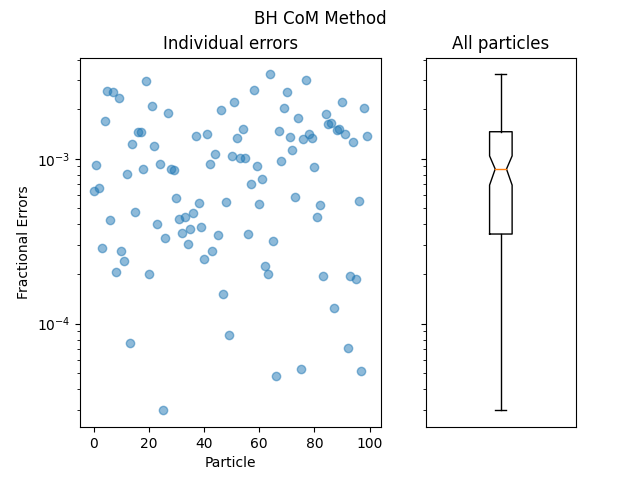

In [9]:
report_plots.bh_com_error(bh_com_potentials, pair_potentials)

Note that for this plot, and all proceeding, boxplots show the median, 1<sup>st</sup> and 3<sup>rd</sup> quartiles as central line and box, the total range is shown with the two whiskers. 

As can be see, this method is effective, offering errors below one in one hundred. However, there remain some issues with the method. 
The first being that as it stands, the only way to increase accuracy within this method is to reduce the value of `theta`, corresponding to requiring cells to be further before they are considered far away, while this is possible, only marginal gains are possible (See later Error analysis) whilst still keeping `theta` large enough that performance gains are as expected. 

Secondly, this method also is very poor when considering both positive and negative charges. This arises as there is no truely useful concept of 'centre of charge'. For charge distributions that are both positive and negative, consideration of dipole and then further multipole moments is required for reasonable approximation of far-field effects. 

### Multipole Approximation

The multipole from a collection of points is simply an expansion of the potential, which converges in the far-field. This is then truncated within computational methods, to get an approximation of these far field effects. As given in by Greengard et al., the expansion at a point $z$ with $|z| > r$, due to $m$ charges each with $|z_i| < r$, is, 
$$
\phi(z) = \sum_{i=1}^m q_i \log(z - z_i) = Q \log(z) + \sum_{k=1}^{\infty} \frac{a_k}{z^k} \, ,
$$
with, 
$$
Q = \sum_{i=1}^{m} q_i \, , \quad a_k = \sum_{i=1}^m \frac{-q_i z_i^k}{k} \, .
$$
This converges given $z$ is outside the charge distribution contained within a circle radius $r$. (Note again this is given for potentials of the form $+ \log(z - z_0)$ instead of the technically more correct negative sign). 

Using this formulation at each leaf cell, a multipole expansion can be constructed. 
The multipole can then be propogated up the tree, using the Multipole to Multipole (M2M) equation. 
Consider the child cell to have centre $z_0$, of which its multipole is 'about', for the parent taken at the origin, the child's multipole will be
$$
\phi(z) = a_o \log(z - z_0) + \sum_{k=1}^{\infty} \frac{a_k}{(z - z_0)^k} \, ,
$$
a translation of the equation above. This can then be translated to be about the origin as
$$
\phi(z) = a_0 \log(z) + \sum_{l=1}^{\infty} \frac{b_l}{z^l}
$$
with, 
$$
b_l = - \frac{a_0 z_0^l}{l} + (\sum_{k=1}^l a_k z_0^{l-k} \binom{l-1}{k-1}) \, .
$$
This will converge for the circle radius $R + z_0$ about the origin, where $R$ is the radius of convergence of the child. 

Performing this for each child, and then summing the results allows calculation of a parent's multipole, and therefore propogation of the multipole up the tree. 

Hence the previous method is slightly modified. Using 4 terms in the expansion we have. 

In [10]:
import importlib
importlib.reload(report_plots)

<module 'report_plots' from '/Users/liambrown/repositories/computing-project-lb880/report_plots/__init__.py'>

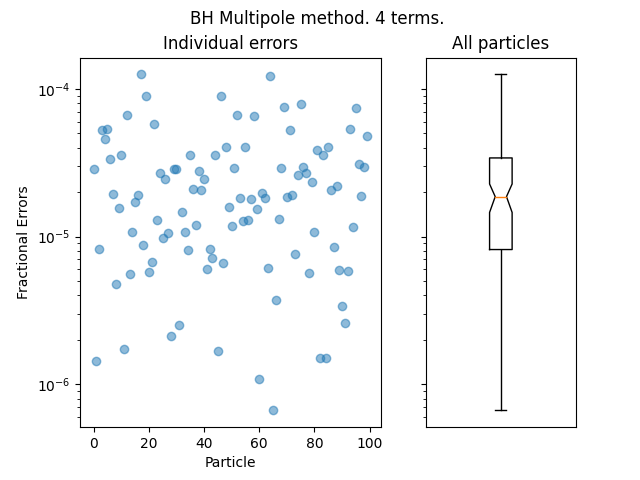

In [11]:
terms = 4

reset_particle_values(particles)
bh_multi_method = bh.BH(particles, 0.5, terms)
bh_multi_method.create_root()
bh_multi_method.root.create_tree()
bh_multi_method.root.populate_multipoles()
bh_multi_method.root.evaluate_particle_potentials()

bh_multi_potentials = np.array([p.potential for p in particles])
bh_multi_forces = np.array([p.force_per for p in particles])

fig = report_plots.bh_multi_error(bh_multi_potentials, pair_potentials, terms)

Immediately it can be seen that this has reduced the errors within the method. Further terms will continue to lower these (see later section on errors). This method is also now applicable to both positive and negative charges. 

## Fast Multipole Method

We now move to the complete implementation of the Fast Multipole Method (FMM) as presented by Greengard and Rokhlin 1987. This method extends the use of various expansions in such a way that the time scaling becomes $O(N)$ for large $N$. This is achieved by calculating a local expansion also for each cell. This local expansion converges within the cell of interest, and will approximate the far-field interactions that will be felt by particles in the cell. 

As per the method presented by Greengard and Rokhlin, the space is still subdivided, however now no longer in a tree structure, rather as a series of increasing finer grained grids of cells. A parent-child relation does still remain, with each parent having 4 'children' in the lower Level, akin to the quadrants in the Barnes-Hut method. Within this structure, consideration of nearest neighbours is common. An "interaction list" for each cell is also introduced, consisting of all other cells within the same level that are children of the parents nearest neighbours, but not the child's nearest neighbour. Indexing each of the cells within the matrix as a 2D `Tuple` a `Cell` class for this method (found at [packages/fmm/cell.py](packages/fmm/cell.py)) was created to handle this. 

The method begins with the calculation of multipole coefficients within each cell in the finest grained level, due to the particles contained within each (should there be any). As in Barnes-Hut, the Multipole-to-Multipole method can then be used to propogate these up to parents, and therefore all cells in coarser grained levels. This constitutes the upwards path. 

Unlike with the BH method, a downwards pass is then also performed. Moving down from the coarsest levels, local expansions for each cell are calculated, and then propogated to children. This is achieved in two parts, first Multipole-to-Local (M2L), and then Local-to-Local (L2L). 

Starting with Multipole-to-Local, consider a cell and its corresponding interaction list. For each 'interactor' in this set, the formula below is applied to construct a local expansion of the effects of the multipole of that cell. For a multipole expansion in the interactor cell (located at $z_0$) of the form, 
$$
\phi(z) = b_0 \log(z - z_0) + \sum_{k=1}^{\infty} \frac{b_k}{(z - z_0)^k} \, ,
$$
the local expansion for the cell of interest
$$
\phi(z) = \sum_{l=0}^{\infty} c_l z^l
$$
will have coefficients
$$
c_0 = a_0 \log(-z_0) + \sum_{k=1}^{\infty} \frac{b_k}{z_0^k}(-1)^k \, , \quad
c_l = \frac{-b_0}{l z_0^l} + \frac{1}{z_0^l} \sum_{k=1}^{\infty} \frac{b_k}{z_0^k} \binom{l+k-1}{k-1} (-1)^k \, \text{ for } l \geq 1 \, .
$$
For the multipole expansion (at $z_0$) describing charges inside a circle radius $R$, this local expansion converges inside a similar circle radius $R$ centered on the origin. Hence for cells that are not nearest neighbours (so the multipole converges), this local expansion converges inside the whole circle of interest. 

As this is just a linear sum, coefficients from all expansions in a cells interaction list can simply be summed. Note also that for free space conditions, the regions at which cells should be for the coarsest two levels are empty (i.e. the coarsest two levels have no interaction list), and give $\phi(z) = 0$ as a local expansion, hence this process can be started with the third coarsest level. 

Starting at this level and performing M2L for every cell, a representation for the far-field interactions for every cell is constructed. To propogate this local expansion to children cells the Local-to-Local method is used. This is simply the translation of a Taylor series, so for a parent located at $z0$ with local expansion of the form $\phi(z) = \sum_{k=0}^{n} c_k (z-z_0)^k$, the child located at the origin will have expansion
$$
\phi(z) = \sum_{l=0}^{n} d_l z^l \, ,
$$
with
$$
d_l = \sum_{k=l}^n a_k \binom{k}{l} (-z_0)^{k-l} \, .
$$

Note that as this method is just a translation, there is no error bound in the operation on a truncated series. 

Having completed L2L for all cells in a parent level, the results of M2L from interaction lists can be added to this. This produces a set of local coefficients for each cell in the child level. These two methods can then be repeated down the entire structre, with the end goal being a set of local coefficients for the finest level. 

Due to the nature of the interaction lists as we move down the strucuture, each of these local expansions represent the complete contribution to far-field interaction for a given cell, with no cells double counted or missed. Hence to evaluate a given particle, the local expansion can be evaluated for the far-field, summed with near-field contribution from all particles within the same cell and nearest-neighbour cells. 

The total number of levels is chosen such that for a reasonably uniform collection of particles, there will be roughly one particle per cell at the finest grain, hence a max level number (indexed from $0$) of $l = \text{floor}[\frac{1}{2} \log_2(N)]$. (As there are $2^l$ cells in level $l$). 

Implementation of this was achieved with a `Level` class ([packages/fmm/level.py](packages/fmm/level.py)), containing the methods described above, and a further `FinestLevel` to manage initial creation of multipoles, 'storage' of particles in each cell, and their eventual evaluation. The overall method is then encapsulated in the `FMM` class in [packages/fmm/fmm.py](packages/fmm/fmm.py). 

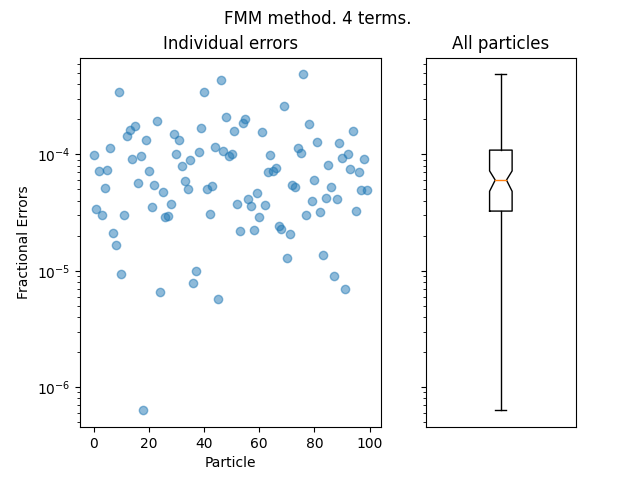

In [12]:
terms = 4

reset_particle_values(particles)
fmm_method = fmm.FMM(particles, terms)
fmm_method.finest_level.populate_with_particles(particles)
# Initial multipoles, and M2M
fmm_method.upward_pass()
# M2L and L2L
fmm_method.downward_pass()
fmm_method.finest_level.evaluate_particles()

fmm_potentials = np.array([p.potential for p in particles])
fmm_forces = np.array([p.force_per for p in particles])

fig = report_plots.fmm_error(fmm_potentials, pair_potentials, terms)

For the same number of terms we see that there is a greater error associated than for the BH Multipole method, however, in a similar way, increasing the number of terms will decrease these errors (see later error analysis). 

# Results and Discussion

Various tests on the methods were conducted using notebooks found in [tests](tests). 

In [13]:
import tests

Of primary consideration within these methods (with relation to direct pairwise) are the errors produced by each, and their time scaling. These are considered here for the overarching methods, and later for the individual variables that can be set within each method. 

Beginning with a general overview, below are error and timing tests for the various methods used. 

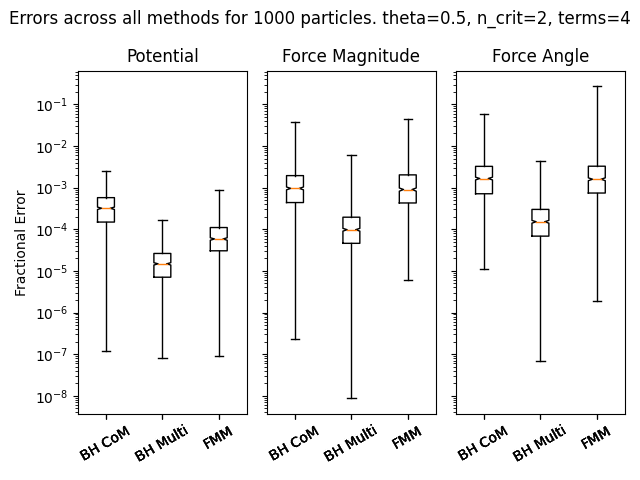

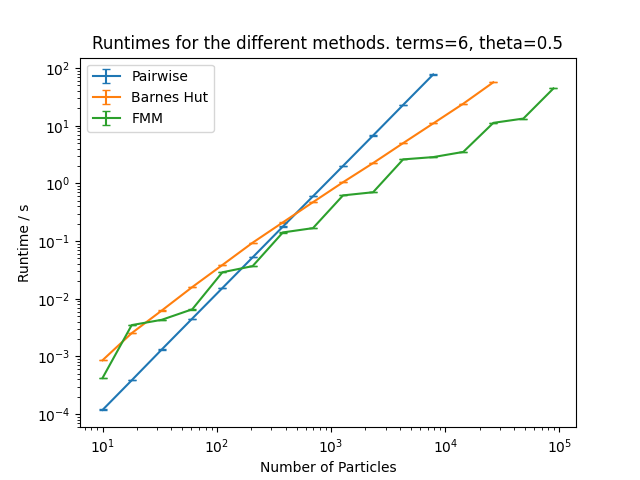

In [14]:
fig_err = tests.errors.plots.general('tests/errors/data/general.npz')
fig_time = tests.timings.plots.general('tests/timings//data/general.npz')

Errors are given relative to pairwise interaction. For the errors, mass-like particles were used, with the BH CoM method corresponding to the monopole (or centre of mass) approximation, and BH Multi to the multipole method (which, along with FMM, contained 4 terms here). Using 4 terms is seen to produce results similar to the BH CoM for FMM, and (as expected) the BH Multipole method improves on this. Effects of further terms are later considered. 

It can also be seen that Force results generally have greater errors than Potential. Considering the multipole approximations taken, this will be due to the first coefficient no longer being considered in force calculation, effectively shortening the expansion. For the same number of terms, we also note here that BH will perform better than FMM, due to the downwards path within FMM introducing additional errors, further to those in the upwards path that is shared with BH. 

Timings for one iteraction of each algorithm are plotted for Pairwise interaction, Barnes-Hut (multipole) and Fast Multipole Method. Both multipole methods used 6 terms. In general, we see expected forms for each of the methods. With pairwise having the worst scaling at large $N$, FMM having the best, and Barnes-Hut in the middle but still very similar to FMM for smaller N. Further analysis can be found in the later section on Timings. 

## Errors

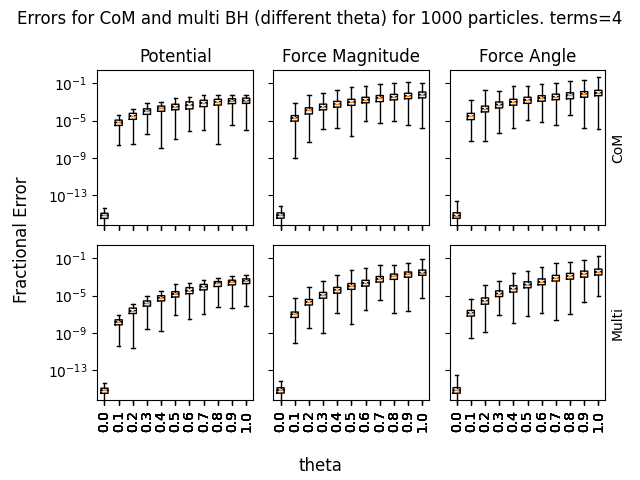

In [15]:
fig = tests.errors.plots.theta('tests/errors/data/theta.npz')

Starting with Barnes_hut, errors due to differing values of `theta` are first considered. This was analysed for both the centre of mass and multipole versions of this method. As expected, `theta=0` gives the lowest errors, as this effectively just corresponds to pairwise itself. Increasing `theta` will then start to designate more of the close and/or large cells as far than lower values. This will therefore decrease the precision of the method. Increasing `theta` however will of course decrease computation time as less pairwise interactions need to be performed. 

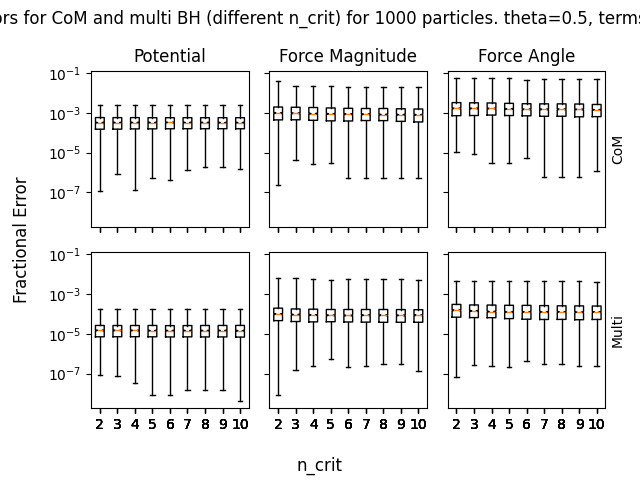

In [16]:
fig = tests.errors.plots.n_crit('tests/errors/data/n_crit.npz')

Within the Barnes-Hut method, it can briefly be noted the effect of `n_crit` on errors, or more accurately, the lack of it. It is seen that different values have little effect on the median or maximum values of the error. 

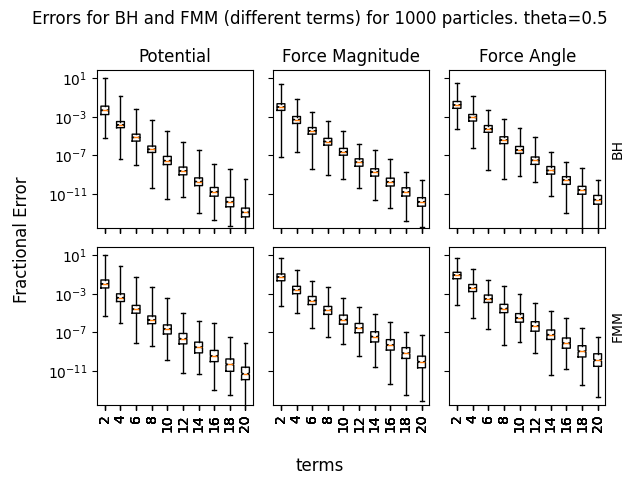

In [17]:
fig = tests.errors.plots.terms('tests/errors/data/terms.npz')

For both the Barnes-Hut and FMM method, we can see the effects of increasing number of terms on the errors produced. As expected, consideration of higher order moments will increase accuracy, as far-field interactions are better accounted for within the method. As previously noted, we also see that Barnes-Hut generally has better errors for the same number of terms, due to the lack of the additional downwards pass from FMM. 

As given by Greengard et al. the fractional precision of the FMM method in particular is expected to be exponential in the number of terms ($\text{error} \leq 2^{\text{terms}}$), which is seen here, with linear relation on the y-log plot. 

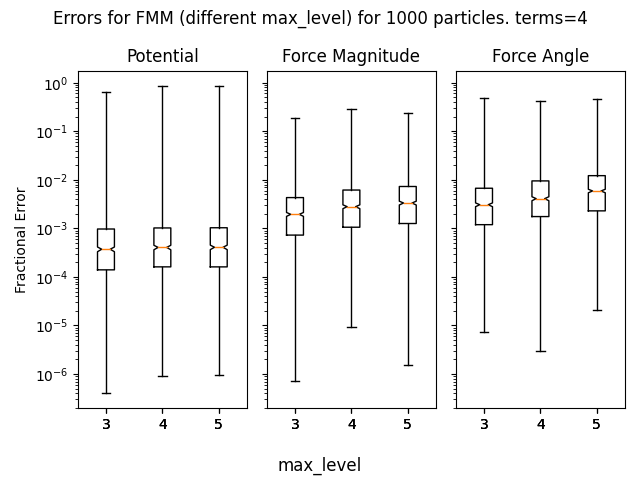

In [18]:
fig = tests.errors.plots.max_level('tests/errors/data/max_level.npz')

Finally the effects of different `max_level`s for the FMM method are considered. For 1000 particles, the default value of `max_level` is 4. It is seen that changing this has no considerable effect on the errors, in a manner similar to Barnes-Hut with the `n_crit` parameters. 

## Timings

Of primary importance within this project are the computational times, as related to varying $N$. Fits to power laws of the form $A N^p$ are shown below. For the FMM, a second fit with the first 5 points removed is also shown. 

Pair Order: 2.0076885375800244
BH Order:   1.3785739670295947
FMM Order:  1.170732639397326
FMM Trun:   1.0666269163224413


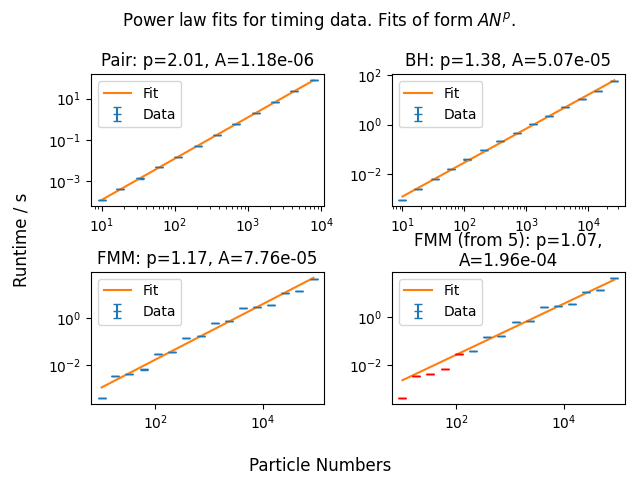

In [19]:
fig = tests.timings.orders.general('tests/timings/data/general.npz', truncation=5)

As expected, Pairwise interaction is $O(N^2)$, and fits this strongly for the whole range of $N$ considered. For the FMM, the fit gives very close to $O(N)$, when we exclude the initial five data points. Fitting to the entire data set however gives $p=1.17$, suggesting that there are some other effects that become less prevalent at larger $N$. 

The Barnes-Hut method quite reasonably fits a power law within the ranges of data considered, with $p=1.38$. Giving performance between pairwise and FMM for large $N$. A fit of the form $B N \log(C N)$ is also considered below. 

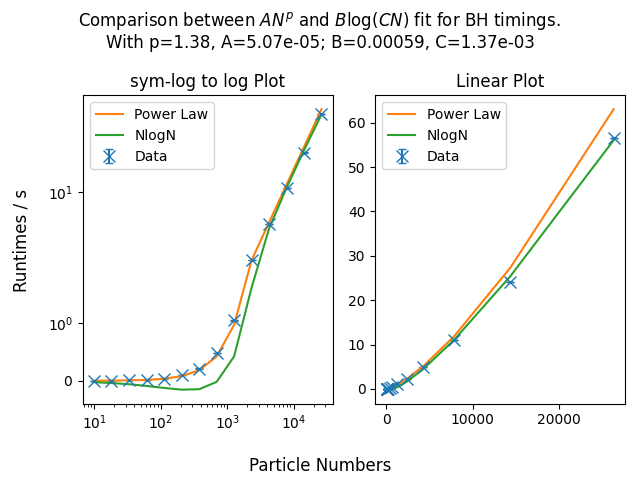

In [20]:
fig = tests.timings.orders.bh_NlogN('tests/timings/data/general.npz')

The power law and $N \log(N)$ fit are both plotted; the right is plotted with log scale axis (symlog on y axis as the fit verges into the negatives for small $N$), and the left is plotted with linear axes. We can see that for the log scale plot, the power law appears to fit best for most of the data. However this plot does place more significance on the small $N$ results. Looking instead for large $N$ (better shown on the right) we see that the $N \log(N)$ fit becomes better for this large $N$, suggesting this is a more appropriate limit for larger $N$. 

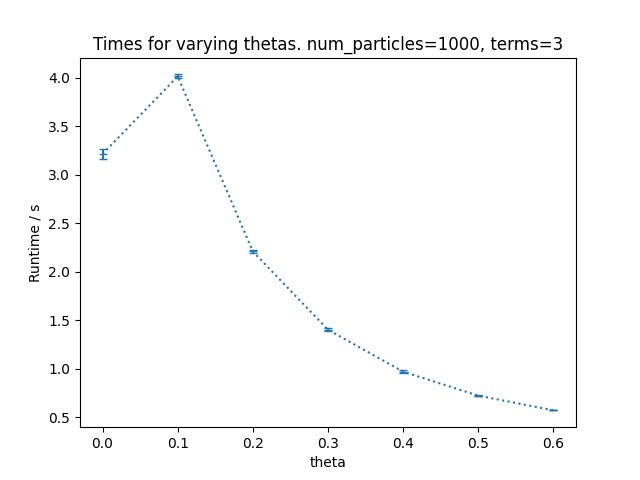

In [21]:
fig = tests.timings.plots.theta('tests/timings/data/theta.npz')

Moving towards results from the individual parameters and their effects, effects of the `theta` parameter for Barnes-Hut can be considered. As expected, raising `theta` will generally lower the runtime for a cycle, as more cells will be considered far, reducing the number of pairwise interactions that need to be considered. We do see that lowering `theta` to $0$ (corresponding to always considering pairwise) is faster than small values of `theta`. This is likely due to the operational cost of calculating relative to `theta` no longer seeing its associated gain in less interactions to calculate. 

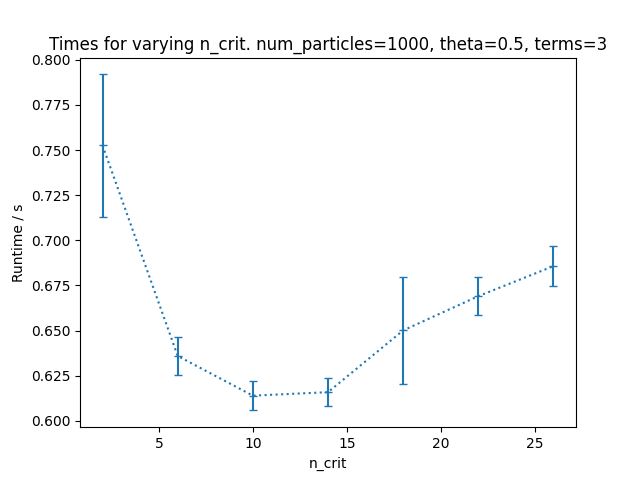

In [22]:
fig = tests.timings.plots.n_crit('tests/timings/data/n_crit.npz')

Within the Barnes-Hut algorithm, the value of `n_crit` can also be adjusted, controlling the number of particles that need to be found in a cell before it splits. The results here show a minimum for `n_crit` near 10 particles. It is expected that this minimum is present due to the balancing of the computational cost of traversing the tree, versus pairwise interaction. `n_crit` effectively controls the coarseness of the finest cells, so higher values mean that less of the total particles will be considered under far field, which means more pairwise interaction. However, this comes at the cost of more time in tree creation, and searching through the tree. 

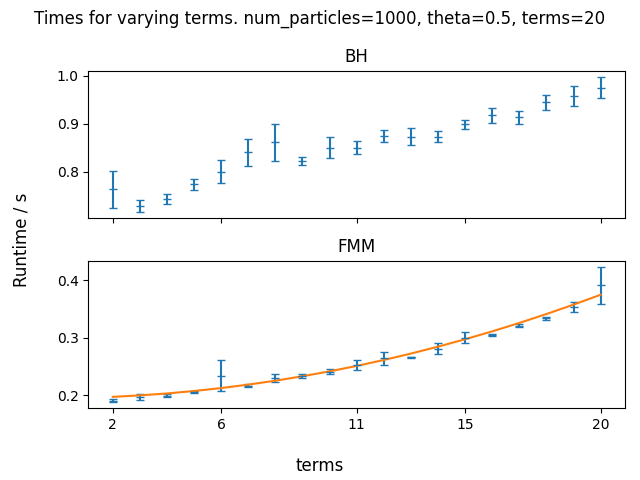

In [23]:
fig = tests.timings.plots.terms('tests/timings/data/terms.npz')

For both the Barnes-Hut (Multipole) and FMM methods the number of terms considered can be adjusted. This will affect the accuracy of the results given, as higher order moments are considered. However this comes at the cost of increasing computational time, and memory usage. This increase in compute time should however be constant with varying $N$ (up to a point of adaquate amounts of memory etc.), and therefore is mainly just multaplicative of overall compute time. For FMM in particular within the method, time depandance on N is expected to be quadratic in form, a behaviour that is seen, coefficients for a fit of $a N^2 + b N + c$ are given below, with the fit also plotted above. 

In [24]:
params, _ = tests.timings.fits.fmm_terms('tests/timings/data/terms.npz')
params

array([0.00043119, 0.00035926, 0.19505245])

Nonetheless, in both cases, the effect of more terms is small compared to the compute cost of simply having more particles. As can be seen, with the actual time increase of 10 times the number of terms being very far from 10 times also, and worst case with FMM that only doubling in compute time. 

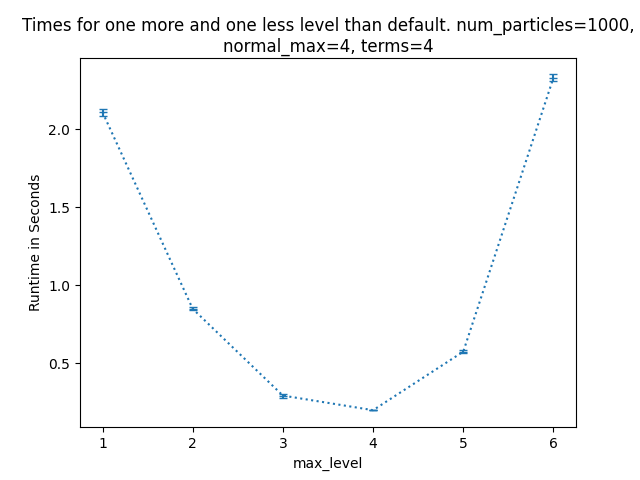

In [25]:
fig = tests.timings.plots.max_level('tests/timings/data/max_level.npz')

Finally we consider the effect of different maximum levels in FMM. As suggested by Greengard et al., the default `max_level` used is chosen so as to have roughly one particle per cell on the finest level. For 1000 particles, this gives a recommendation of `max_level=4`. 
As can be seen from the timing data, this is the most efficient choice, providing the shortest computation time. Note that as in the consideration of errors, there is negligible difference in the errors different max levels will produce, hence we are validated in our choice of `max_level`. 
Too coarse a finest level will required many more pairwise interactions, and too fine a `max_level` will introduce unnecessary cells (roughly 4 times more), of which many will be empty. 
It can also be noted here that for FMM, as seen in the overall timing tests, the computation time increases in steps. These correspond to the addition of extra levels, suggesting the algorithm is more sensitive to the number of levels than number of particles given a reasonaly correct `max_level` is still chosen. 

# Simulation

These methods can of course be applied to produce many body simulations. In the current form, having been written in Python, this codebase is difficult to considerably use for this purpose, as computation times are very large. Nonetheless, simulations were computed for completeness. 
These were run with code in [animation](animation), with integration handled by the `Universe` class ([animation/universe.py](animation/universe.py)). A Runge-Kutta (RK4) integration scheme was used, in an attempt to increase the stability of the simulations. 

The simulations below consider the particles to be confined to the box, with free space conditions outside. Collisions with the box are elastic (with velocities simply reflected on impact). A collection of 'protons' and 'electrons' with opposite charges and inertial masses in the ratio of $1000:1$ are used. A multiplicative value of $k=1$ (like repulsive) was simply used for the force law. 

A simulation over a large timescale for 32 particles total is first considered below. Kinetic, potential, and the total energies are also shown. (All videos can be found at [Figures/Animations](Figures/Animations)). 

In [26]:
Video('Figures/Animations/BH_Long_Time.mp4', width=600)

[BH Large Time](Figures/Animations/BH_Long_Time.mp4). 

There can be seen a brief period of stability in the total energy, after an initial period of increase. Following this however, a large spike in the kinetic energy is seen. This will be due to divergences in the system, a common problem within numerical many body interaction. These are caused by near particles reaching very high speeds, with the timestep then too small for decleration as the particles later move away. Full treatment to resolve these will often introduce softening in the force law (to prevent division by very small numbers), and the use adaptive timesteps within the integration scheme. These are not considered here. 

The algorithms investigated in this report are of course most useful for large values of $N$, where complete pairwise interaction would become infeasible. Simulations with 2048 particles (in a similar setup to those above) are shown below, for both the Barnes-Hut and FMM methods. 

In [27]:
Video('Figures/Animations/BH_Large_Number.mp4', width=600)


In [28]:
Video('Figures/Animations/FMM_Large_Number.mp4', width=600)

[BH Large Number](Figures/Animations/BH_Large_Number.mp4), [FMM Large Number](Figures/Animations/FMM_Large_Number.mp4). 

Qualitatively expected behaviour is seen in the Barnes-Hut simulation, with the 'electrons' distributing among the 'protons' for a more even charge distribution. Energy conservation is reasonable however it can still be seen to increase over even the short time considered. For the FMM case, a similar behaviour is initially seen, however, the kinetic energy within the system quickly ran away in this simulation. 

# Conclusions

Within this project, two improvements to the naive Pairwise algorithm for many body interaction were considered. These being the Barnes-Hut algorithm and Fast Multipole method. These were implemented, and expected timescaling for large $N$ was seen, with O(N^2) for Pairwise, O(N) for FMM, and Barnes-Hut beginning to resemble $O(N \log(N))$ for the larger $N$. Errors for the various methods were considered, and it was shown that adjustment of various parameters within the methods can be tuned to reduce these as needed. The effects on the computational times of these parameters were also considered, with parameter adjustments made to reduce errors typically increasing computation time. In some cases, such as BH's `n_crit` FMM's `max_level`, it was seen that these parameters have little effect of errors, but can have significant effects on runtimes. 

These methods were also then applied to a many body simulation. However, having been written in Python, computing very large particle numbers or large timescales quickly becomes prohibative. Additionally, divergences in the particles forces and potentials caused issues in energy conservation, with many particles reaching unphysical speeds. 

Nonetheless, the code presented here serves as a good demonstration of the various methods and their benefits, showing expected error and runtime dependancies, especially when applied to large numbers of particles. 

# References

Josh Barnes and Piet Hut. ‘A hierarchical O(N log N) force-calculation algorithm’. In: Nature 324.6096 (Dec. 1986), pp. 446–449. issn: 1476-4687. doi: [10.1038/324446a0](https://doi.org/10.1038/324446a0).

L Greengard and V Rokhlin. ‘A fast algorithm for particle simulations’. In: Journal of Computational
Physics 73.2 (1987), pp. 325–348. issn: 0021-9991. doi: [10.1016/0021-9991(87)90140-9](https://doi.org/10.1016/0021-9991(87)90140-9).

Barbagroup. Barbagroup/FMM tutorial: A step-by-step introduction to treecode. 2016. url: [https://github.com/barbagroup/FMM_tutorial](https://github.com/barbagroup/FMM_tutorial).